# Proyecto 1

In [4]:
import sys
!{sys.executable} -m pip install numpy

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
db_location = 'incident_event_log.csv'

In [7]:
df = pd.read_csv(db_location, sep=',', encoding = "ISO-8859-1")

In [8]:
df.shape

(141712, 36)

In [9]:
df.dtypes

number                     object
incident_state             object
active                       bool
reassignment_count          int64
reopen_count                int64
sys_mod_count               int64
made_sla                     bool
caller_id                  object
opened_by                  object
opened_at                  object
sys_created_by             object
sys_created_at             object
sys_updated_by             object
sys_updated_at             object
contact_type               object
location                   object
category                   object
subcategory                object
u_symptom                  object
cmdb_ci                    object
impact                     object
urgency                    object
priority                   object
assignment_group           object
assigned_to                object
knowledge                    bool
u_priority_confirmation      bool
notify                     object
problem_id                 object
rfc           

Para comprender de mejor manera los datos, decidimos hacer un diagrama de barras que muestre cómo se distrubuye cada variable categórica.

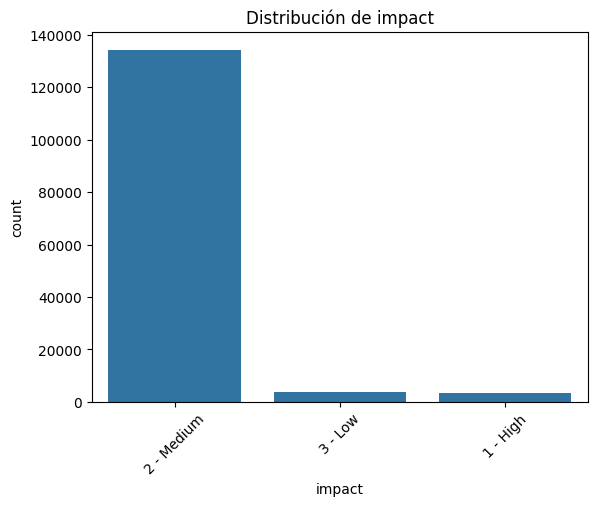

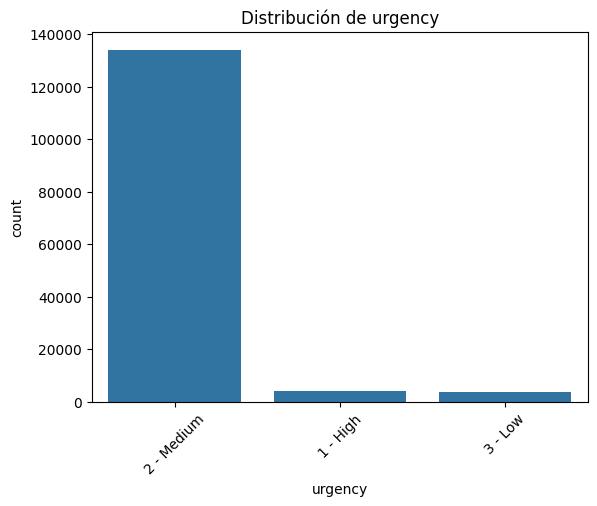

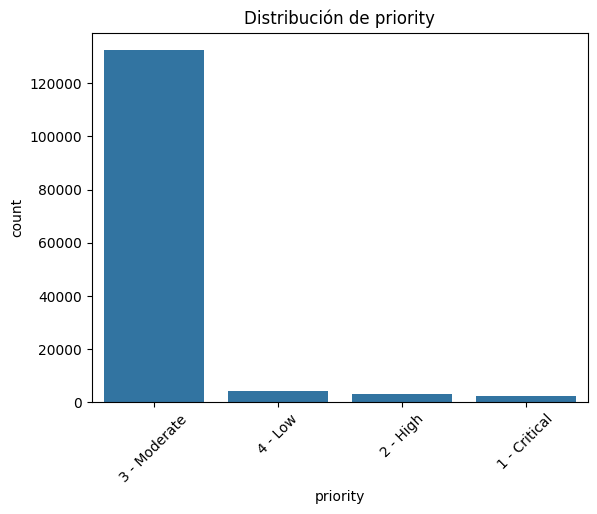

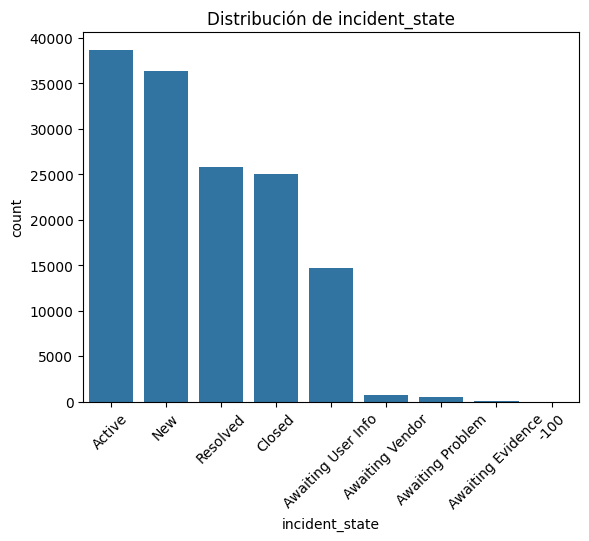

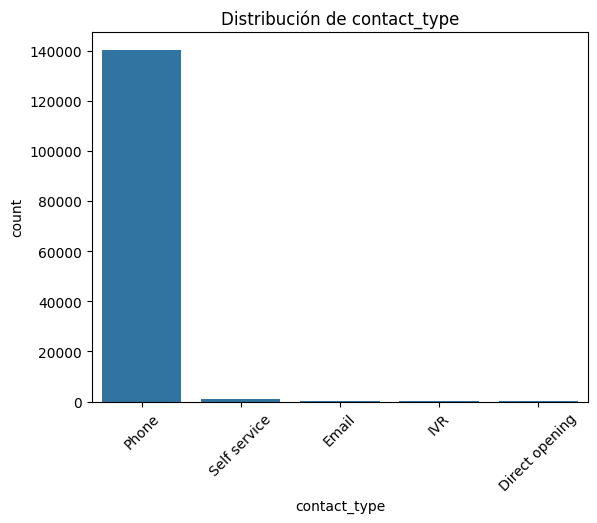

In [10]:
cat_vars = ["impact", "urgency", "priority", "incident_state", "contact_type"]

for col in cat_vars:
    plt.figure()
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f"Distribución de {col}")
    plt.xticks(rotation=45)
    plt.show()

De lo anterior cabe resaltar que *incident_state* tiene una categoría (-100) que parece no pertenecer al conjunto. Esto se debe corregir en la fase de limpieza.

Si bien nuestro objetivo es predecir la duración, debemos de saber si tomaremos *resolved_at* o *closed_at*. En primer lugar, anteriormente vimos que ambas columnas eran de tipo "object", entonces hay que cambiarlas a tipo fecha.

In [11]:
df["resolved_at"] = pd.to_datetime(df["resolved_at"], format="%d/%m/%Y %H:%M", errors="coerce")
df["closed_at"]   = pd.to_datetime(df["closed_at"], format="%d/%m/%Y %H:%M", errors="coerce")

In [12]:
df["delta_cierre_horas"] = (df["closed_at"] - df["resolved_at"]).dt.total_seconds() / 3600
df_filtrado = df[(df["delta_cierre_horas"] >= -24) & (df["delta_cierre_horas"] <= 720)]

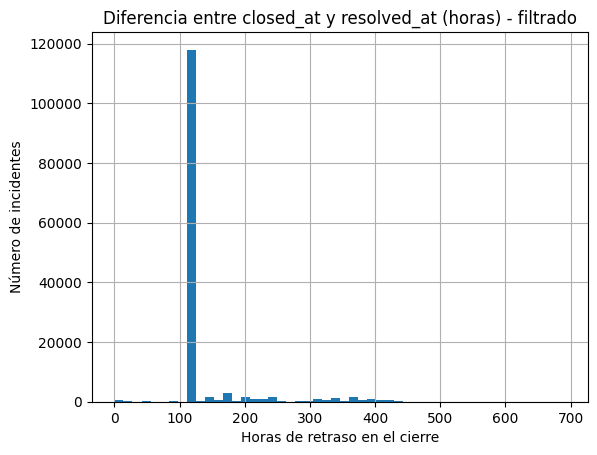

In [13]:
df_filtrado["delta_cierre_horas"].hist(bins=50)
plt.title("Diferencia entre closed_at y resolved_at (horas) - filtrado")
plt.xlabel("Horas de retraso en el cierre")
plt.ylabel("Número de incidentes")
plt.show()

Entonces, como nuestro objetivo es predecir la duración de un nuevo incidente, y observamos que el tiempo de cierre puede contener factores externos que afecten dicha variable, decidimos tomar el tiempo de resolución ya que da información más puntual en cuanto a la eficiencia de resolución de incidentes.

In [14]:
df["opened_at"]   = pd.to_datetime(df["opened_at"],   format="%d/%m/%Y %H:%M", errors="coerce")
df["duracion_horas"] = (df["resolved_at"] - df["opened_at"]).dt.total_seconds() / 3600
df = df[df["duracion_horas"] >= 0]

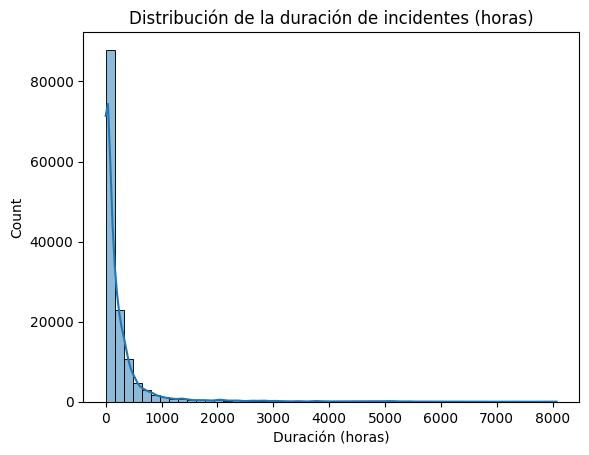

In [15]:
plt.figure()
sns.histplot(df["duracion_horas"], bins=50, kde=True)
plt.title("Distribución de la duración de incidentes (horas)")
plt.xlabel("Duración (horas)")
plt.show()

In [16]:
display(df["duracion_horas"].describe())

count    138571.000000
mean        269.596262
std         650.867377
min           0.000000
25%           4.066667
50%          73.516667
75%         262.183333
max        8070.166667
Name: duracion_horas, dtype: float64

Como se observa, la mayoría de incidentes tienen una duración baja, por lo que limitemos los resultados para observar de mejor manera el comportamiento

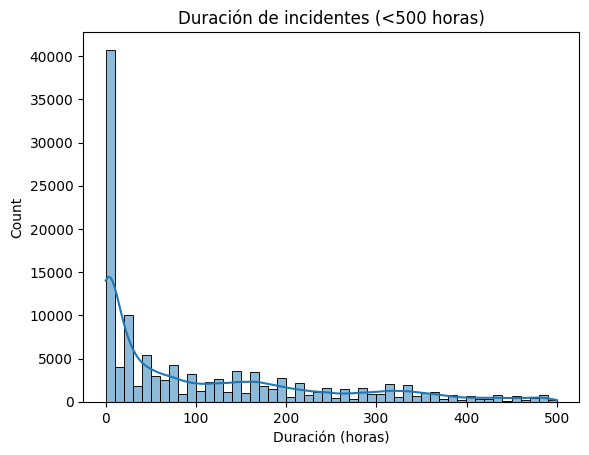

In [17]:
sns.histplot(df[df["duracion_horas"] < 500]["duracion_horas"], bins=50, kde=True)
plt.title("Duración de incidentes (<500 horas)")
plt.xlabel("Duración (horas)")
plt.show()

Ahora queremos ver cómo se distribuye la duración de un incidente dado su impacto, urgencia y prioridad.

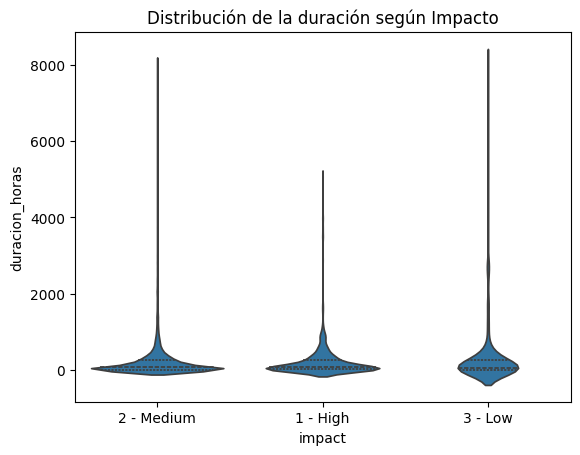

In [18]:
plt.figure()
sns.violinplot(data=df, x="impact", y="duracion_horas", inner="quartile")
plt.title("Distribución de la duración según Impacto")
plt.show()

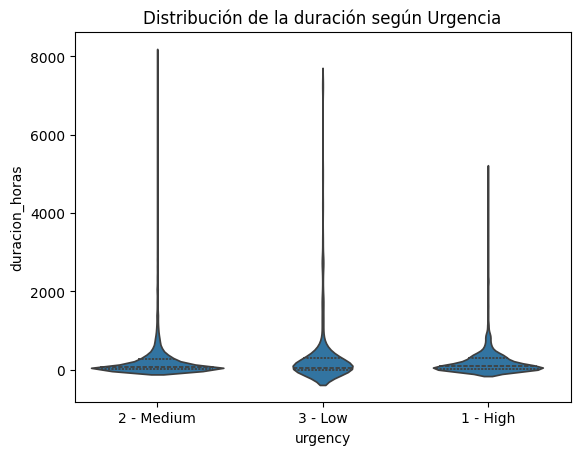

In [19]:
plt.figure()
sns.violinplot(data=df, x="urgency", y="duracion_horas", inner="quartile")
plt.title("Distribución de la duración según Urgencia")
plt.show()

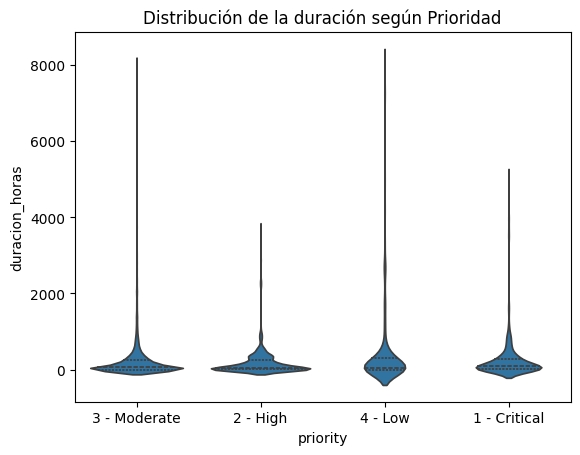

In [20]:
plt.figure()
sns.violinplot(data=df, x="priority", y="duracion_horas", inner="quartile")
plt.title("Distribución de la duración según Prioridad")
plt.show()

Ahora nos parece interesante ver si existe relación entre algunas variables numéricas (como número de reasignaciones/reaperturas) con la duración del incidente.

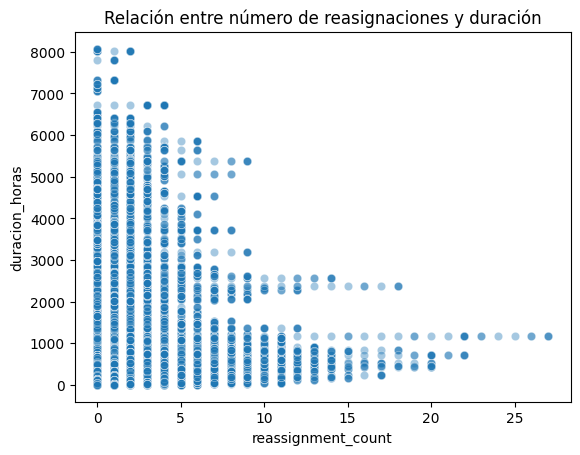

In [21]:
plt.figure()
sns.scatterplot(data=df, x="reassignment_count", y="duracion_horas", alpha=0.4)
plt.title("Relación entre número de reasignaciones y duración")
plt.show()

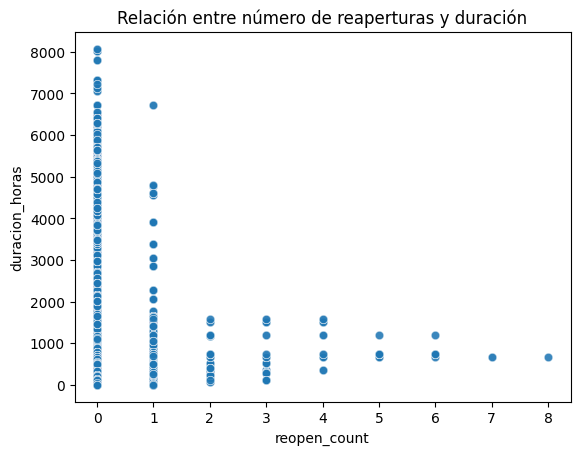

In [22]:
plt.figure()
sns.scatterplot(data=df, x="reopen_count", y="duracion_horas", alpha=0.4)
plt.title("Relación entre número de reaperturas y duración")
plt.show()

Finalmente, es importante conocer las correlaciones entre variables numéricas.

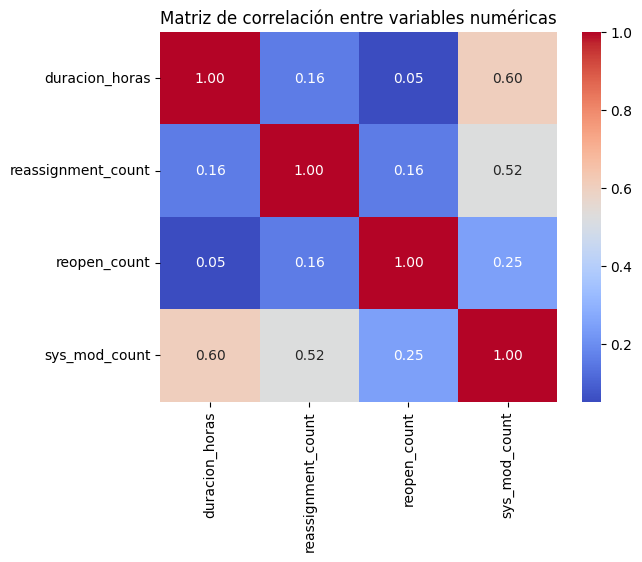

In [23]:
corr = df[["duracion_horas", "reassignment_count", "reopen_count", "sys_mod_count"]].corr()

plt.figure()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación entre variables numéricas")
plt.show()

## Limpieza

In [24]:
df.head(5)

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,...,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at,delta_cierre_horas,duracion_horas
0,INC0000045,New,True,0,0,0,True,Caller 2403,Opened by 8,2016-02-29 01:16:00,...,?,?,?,?,code 5,Resolved by 149,2016-02-29 11:29:00,2016-03-05 12:00:00,120.516667,10.216667
1,INC0000045,Resolved,True,0,0,2,True,Caller 2403,Opened by 8,2016-02-29 01:16:00,...,?,?,?,?,code 5,Resolved by 149,2016-02-29 11:29:00,2016-03-05 12:00:00,120.516667,10.216667
2,INC0000045,Resolved,True,0,0,3,True,Caller 2403,Opened by 8,2016-02-29 01:16:00,...,?,?,?,?,code 5,Resolved by 149,2016-02-29 11:29:00,2016-03-05 12:00:00,120.516667,10.216667
3,INC0000045,Closed,False,0,0,4,True,Caller 2403,Opened by 8,2016-02-29 01:16:00,...,?,?,?,?,code 5,Resolved by 149,2016-02-29 11:29:00,2016-03-05 12:00:00,120.516667,10.216667
4,INC0000047,New,True,0,0,0,True,Caller 2403,Opened by 397,2016-02-29 04:40:00,...,?,?,?,?,code 5,Resolved by 81,2016-03-01 09:52:00,2016-03-06 10:00:00,120.133333,29.200000


Como se observa en esta muestra de datos, los valores nulos están representados por un '?'. Entonces, se reemplaza dicho caracter por un *na* para saber cuántos valores nulos tiene cada columna. Además, decidimos mostralo como un porcentaje para facilitar la interpretación.

In [25]:
df = df.replace("?", np.nan)
porcentaje_nulos = df.isna().mean() * 100
porcentaje_nulos.sort_values(ascending=False)

caused_by                  99.983402
vendor                     99.823917
cmdb_ci                    99.680308
rfc                        99.284843
problem_id                 98.343809
sys_created_at             36.041452
sys_created_by             36.041452
u_symptom                  23.204711
assigned_to                19.734288
assignment_group           10.250341
opened_by                   3.401866
closed_code                 0.507321
subcategory                 0.077938
category                    0.056289
location                    0.052681
resolved_by                 0.051237
caller_id                   0.020928
reopen_count                0.000000
incident_state              0.000000
number                      0.000000
reassignment_count          0.000000
active                      0.000000
sys_mod_count               0.000000
urgency                     0.000000
contact_type                0.000000
impact                      0.000000
opened_at                   0.000000
m

Decidimos eliminar las columnas que están casi vacías (tienen más de un 90% de valores nulos). Además, las columnas *sys_created_by* y *sys_created_at* también fueron eliminadas porque el porcentaje de nulos sigue siendo significativo.

In [26]:
columnas_eliminar = ["caused_by", "vendor", "cmdb_ci", "rfc", "problem_id", "sys_created_by", "sys_created_at"]
df = df.drop(columns=columnas_eliminar)

Ahora, columnas como *u_symptom*, *assigned_to* y *assignment_group* también cuentan con una cantidad considerable de nulos, pero  creemos que cuentan con información valiosa a la hora de predecir la duración. Entonces, decidimos inputarles valores de *No asignado* y *No reportado*.

In [27]:
df["assignment_group"] = df["assignment_group"].fillna("No asignado")
df["assigned_to"] = df["assigned_to"].fillna("No asignado")
df["u_symptom"] = df["u_symptom"].fillna("No reportado")

La duración la calcularemos como *resolved_at - opened_at*, por lo que si un registro no cuenta con alguno de estos atributos, decidimos eliminarlo.

In [28]:
df = df.dropna(subset=["opened_at", "resolved_at"])

Las demás columnas tienen porcentaje de nulos muy bajo, por lo que consideramos adecuado eliminar aquellos registros que tengan algún nulo. Despues de esto, ya no quedan más nulos en el dataframe.

In [29]:
df = df.dropna()
df.isna().sum().sum()

0

In [30]:
df.head(5)

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,...,assigned_to,knowledge,u_priority_confirmation,notify,closed_code,resolved_by,resolved_at,closed_at,delta_cierre_horas,duracion_horas
0,INC0000045,New,True,0,0,0,True,Caller 2403,Opened by 8,2016-02-29 01:16:00,...,No asignado,True,False,Do Not Notify,code 5,Resolved by 149,2016-02-29 11:29:00,2016-03-05 12:00:00,120.516667,10.216667
1,INC0000045,Resolved,True,0,0,2,True,Caller 2403,Opened by 8,2016-02-29 01:16:00,...,No asignado,True,False,Do Not Notify,code 5,Resolved by 149,2016-02-29 11:29:00,2016-03-05 12:00:00,120.516667,10.216667
2,INC0000045,Resolved,True,0,0,3,True,Caller 2403,Opened by 8,2016-02-29 01:16:00,...,No asignado,True,False,Do Not Notify,code 5,Resolved by 149,2016-02-29 11:29:00,2016-03-05 12:00:00,120.516667,10.216667
3,INC0000045,Closed,False,0,0,4,True,Caller 2403,Opened by 8,2016-02-29 01:16:00,...,No asignado,True,False,Do Not Notify,code 5,Resolved by 149,2016-02-29 11:29:00,2016-03-05 12:00:00,120.516667,10.216667
4,INC0000047,New,True,0,0,0,True,Caller 2403,Opened by 397,2016-02-29 04:40:00,...,Resolver 89,True,False,Do Not Notify,code 5,Resolved by 81,2016-03-01 09:52:00,2016-03-06 10:00:00,120.133333,29.200000


### Unificación de registros

In [31]:
df.shape

(133041, 31)

In [32]:
df = df.sort_values(by="resolved_at").drop_duplicates(subset="number", keep="last")

In [33]:
df.shape

(22593, 31)

### Eliminar columnas que no ayudan a la predicción

In [34]:
df = df.drop(
    columns=["incident_state", "active", "sys_updated_by", 
             "sys_updated_at", "closed_at", "delta_cierre_horas","reassignment_count", "reopen_count",
            "sys_mod_count","made_sla", "opened_at", "knowledge", "notify", "closed_code", "resolved_by",
            "resolved_at"],
)

In [35]:
df.shape

(22593, 15)

### Registros con outliers

Como vimos antes en las gráficas de duración, la gran mayoría de los valores de *duracion* están agrupados en valores <1000. Teniendo esto en cuenta, decidimos fijar un valor máximo de 720 horas (1 mes), ya que los incidentes que superan esta duración parecen ser outliers.

In [36]:
df = df[df["duracion_horas"] <= 720]

In [37]:
df.shape

(21497, 15)

In [ ]:
df.sample(10)
#Exportar datos procesados como .csv
#df.to_csv('datos_procesados.csv', index=False)

,number,caller_id,opened_by,contact_type,location,category,subcategory,u_symptom,impact,urgency,priority,assignment_group,assigned_to,u_priority_confirmation,duracion_horas
34778,INC0007753,Caller 1776,Opened by 44,Phone,Location 161,Category 51,Subcategory 25,Symptom 491,2 - Medium,2 - Medium,3 - Moderate,Group 54,Resolver 24,False,1.216667
46502,INC0010484,Caller 2533,Opened by 17,Phone,Location 39,Category 46,Subcategory 231,Symptom 491,2 - Medium,2 - Medium,3 - Moderate,Group 37,Resolver 153,True,532.583333
58069,INC0013424,Caller 1743,Opened by 17,Phone,Location 204,Category 37,Subcategory 174,Symptom 491,2 - Medium,2 - Medium,3 - Moderate,Group 46,Resolver 83,False,0.616667
138875,INC0034141,Caller 2392,Opened by 62,Phone,Location 108,Category 42,Subcategory 223,No reportado,2 - Medium,2 - Medium,3 - Moderate,Group 70,Resolver 33,True,0.033333
56139,INC0012931,Caller 4650,Opened by 17,Phone,Location 204,Category 20,Subcategory 125,Symptom 517,2 - Medium,2 - Medium,3 - Moderate,Group 70,Resolver 140,False,50.983333
111988,INC0027111,Caller 4110,Opened by 17,Phone,Location 161,Category 42,Subcategory 223,Symptom 534,2 - Medium,2 - Medium,3 - Moderate,Group 70,No asignado,False,54.233333
18468,INC0004032,Caller 1665,Opened by 40,Phone,Location 135,Category 26,Subcategory 175,Symptom 120,2 - Medium,2 - Medium,3 - Moderate,Group 20,Resolver 253,False,76.550000
16595,INC0003672,Caller 4772,Opened by 59,Phone,Location 161,Category 45,Subcategory 229,Symptom 267,2 - Medium,2 - Medium,3 - Moderate,Group 70,No asignado,False,356.783333
128117,INC0031331,Caller 456,Opened by 17,Phone,Location 204,Category 19,Subcategory 174,No reportado,2 - Medium,2 - Medium,3 - Moderate,Group 25,Resolver 227,True,0.450000
101460,INC0024596,Caller 3991,Opened by 397,Phone,Location 161,Category 26,Subcategory 175,No reportado,2 - Medium,2 - Medium,3 - Moderate,Group 70,No asignado,False,0.083333
